# 사전 훈련된 PyTorch 모델을 SageMaker Neo로 컴파일하기

---

이 노트북에서는 사전 훈련된 `mnasnet` 모델을 SageMaker Neo로 컴파일하여 배포합니다. SageMaker Neo는 머신 러닝 모델을 하드웨어에 맞게 최적화하는 API로, Neo로 컴파일한 모델은 클라우드와 엣지 디바이스 어디에서나 실행할 수 있습니다.

2021년 1월 기준으로 torchvision의 사전 훈련 모델을 지원하고 있으며 클라우드 인스턴스와 엣지 디바이스에서 PyTorch 1.4.0을 지원하고 있으며, AWS Inferentia에서 PyTorch 1.5.1을 지원하고 있습니다.

SageMaker Neo가 지원하는 인스턴스 타입, 하드웨어 및 딥러닝 프레임워크는 아래 링크를 참조해 주세요.
- 클라우드 인스턴스: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-cloud.html
- 엣지 디바이스: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-devices-edge.html

또한, SageMaker 인프라 상에서 PyTorch로 추론을 수행하는 튜토리얼 노트북 예제는 [pytorch-serving-endpoint.ipynb](pytorch-serving-endpoint.ipynb) 를 참조해 주세요.

In [1]:
%load_ext autoreload
%autoreload 2

SageMaker SDK를 최신 버전으로 업그레이드합니다. 본 노트북은 SDK 2.x 버전 이상에서 구동해야 합니다.

In [2]:
import sys, sagemaker
!{sys.executable} -m pip install -qU "sagemaker>=2.11.0"
print(sagemaker.__version__)

**[주의]** 주피터 노트북에 설치된 PyTorch 및 TorchVision 버전은 각각 1.4.0과 0.5.0이어야 합니다. SageMaker 노트북 인스턴스 상에서 본 예제를 실행한다면 아래 코드 셀을 주석 처리하지 말고 그대로 실행해 주세요.

In [3]:
!~/anaconda3/envs/pytorch_p36/bin/pip install -qU torch==1.4.0 torchvision==0.5.0

<br>

# 1. Inference script
---

아래 코드 셀은 `src` 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

In [4]:
%%writefile src/inference_pytorch_neo.py

import io
import json
import logging
import os
import pickle

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image  # Training container doesn't have this package

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

def model_fn(model_dir):

    logger.info('model_fn')
    with torch.neo.config(model_dir=model_dir, neo_runtime=True):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # The compiled model is saved as "compiled.pt"
        model = torch.jit.load(os.path.join(model_dir, 'compiled.pt'))
        model = model.to(device)

        # It is recommended to run warm-up inference during model load
        sample_input_path = os.path.join(model_dir, 'sample_input.pkl')
        with open(sample_input_path, 'rb') as input_file:
            model_input = pickle.load(input_file)
        if torch.is_tensor(model_input):
            model_input = model_input.to(device)
            model(model_input)
        elif isinstance(model_input, tuple):
            model_input = (inp.to(device)
                           for inp in model_input if torch.is_tensor(inp))
            model(*model_input)
        else:
            print("Only supports a torch tensor or a tuple of torch tensors")

        return model

    
def transform_fn(model, payload, request_content_type='application/octet-stream', 
                 response_content_type='application/json'):

    logger.info('Invoking user-defined transform function')

    if request_content_type != 'application/octet-stream':
        raise RuntimeError(
            'Content type must be application/octet-stream. Provided: {0}'.format(request_content_type))

    # preprocess
    decoded = Image.open(io.BytesIO(payload))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[
                0.485, 0.456, 0.406], std=[
                0.229, 0.224, 0.225]),
    ])
    normalized = preprocess(decoded)
    batchified = normalized.unsqueeze(0)

    # predict
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batchified = batchified.to(device)
    result = model.forward(batchified)

    # Softmax (assumes batch size 1)
    result = np.squeeze(result.detach().cpu().numpy())
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    response_body = json.dumps(result.tolist())

    return response_body, response_content_type


Overwriting src/inference_pytorch_neo.py


<br>

# 2. Import pre-trained model from TorchVision
---
본 예제는 TorchVision의 pre-trained 모델 중 MnasNet을 사용합니다.
MnasNet은 정확도(accuracy)와 모바일 디바이스의 latency를 모두 고려한 강화학습 기반 NAS(neural architecture search)이며, TorchVision은 image classification에 최적화된 MNasNet-B1을 내장하고 있습니다. 
(참조 논문: https://arxiv.org/pdf/1807.11626.pdf)

In [5]:
import torch
import torchvision.models as models
import tarfile

model = models.mnasnet1_0(pretrained=True)

input_shape = [1,3,224,224]
trace = torch.jit.trace(model.float().eval(), torch.zeros(input_shape).float())
trace.save('model.pth')

## Local Inference without Endpoint

충분한 검증 및 테스트 없이 훈련된 모델을 곧바로 실제 운영 환경에 배포하기에는 많은 위험 요소들이 있기 때문에, 로컬 환경 상에서 추론을 수행하면서 디버깅하는 것을 권장합니다. 아래 코드 셀의 코드를 예시로 참조해 주세요.

In [6]:
def get_inference(img_path, predictor, show_img=True):
    with open(img_path, mode='rb') as file:
        payload = bytearray(file.read())

    response = predictor.predict(payload)
    result = json.loads(response.decode())
    pred_cls_idx, pred_cls_str, prob = parse_result(result, show_img)
    
    return pred_cls_idx, pred_cls_str, prob 

def parse_result(result, show_img=True):
    pred_cls_idx = np.argmax(result)
    pred_cls_str = label_map[str(pred_cls_idx)]
    prob = np.amax(result)*100
    
    if show_img:
        import cv2
        import matplotlib.pyplot as plt
        im = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(im, f'{pred_cls_str} {prob:.2f}%', (10,40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        plt.figure(figsize=(10, 10))
        plt.imshow(im[:,:,::-1])    

    return pred_cls_idx, pred_cls_str, prob

In [7]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image
from src.inference_pytorch_neo import transform_fn

path = "./images/imagenet_test"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

test_idx = 0
img_path = img_path_list[test_idx]

with open(img_path, mode='rb') as file:
    payload = bytearray(file.read())

클래스 인덱스에 대응하는 클래스명을 매핑하기 위한 딕셔너리를 생성합니다.

In [8]:
from src.utils import get_label_map_imagenet
label_file = 'files/imagenet1000_clsidx_to_labels.txt'
label_map = get_label_map_imagenet(label_file)

(605, " 'iPod'", 71.57116532325745)

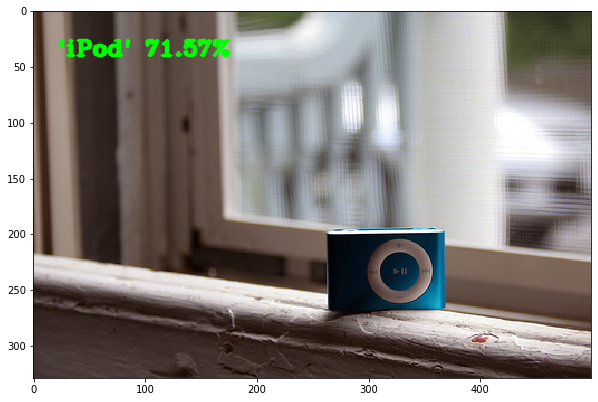

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load('model.pth')
model = model.to(device)

response_body, _ = transform_fn(model, payload)
result = json.loads(response_body)
parse_result(result)

<br>

# 3. Compile the Model
---

## 모델 압축

In [10]:
with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add('model.pth')

In [11]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('TorchVision-MNasNet-Neo')
prefix = compilation_job_name+'/model'

model_path = sess.upload_data(path='model.tar.gz', key_prefix=prefix)

data_shape = '{"input0":[1,3,224,224]}'
target_device = 'ml_c5'
framework = 'PYTORCH'
framework_version = '1.4.0'
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)

In [12]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker_model = PyTorchModel(model_data=model_path,
                               predictor_cls=Predictor,
                               framework_version = framework_version,
                               role=role,
                               sagemaker_session=sess,
                               source_dir='src',
                               entry_point='inference_pytorch_neo.py',
                               py_version='py3',
                               env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
                              )

## 모델 컴파일
SageMaker Neo로 모델을 컴파일합니다. 컴파일된 모델은 s3에 저장되며, 타겟 디바이스 나 타겟 인스턴스에 곧바로 배포할 수 있습니다. 타겟 디바이스 배포 시에는 Neo-DLR 패키지를 이용해 컴파일된 모델을 추론할 수 있습니다. 컴파일된 모델 아티팩트의 경로는 AWS 웹사이트의 SageMaker UI에서도 확인할 수 있고 `compiled_model.model_data`로 가져올 수도 있습니다.
<br>

참조: https://github.com/neo-ai/neo-ai-dlr


In [13]:
%%time
compiled_model = sagemaker_model.compile(target_instance_family=target_device, 
                                         input_shape=data_shape,
                                         job_name=compilation_job_name,
                                         role=role,
                                         framework=framework.lower(),
                                         framework_version=framework_version,
                                         output_path=compiled_model_path
                                        )

?..................!CPU times: user 139 ms, sys: 12.4 ms, total: 152 ms
Wall time: 1min 37s


## 모델 배포

SageMaker가 관리하는 배포 클러스터를 프로비저닝하고 추론 컨테이너를 배포하기 때문에, 추론 서비스를 시작하는 데에는 약 5~10분 정도 소요됩니다.

In [14]:
%%time
predictor = compiled_model.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.c5.xlarge'
                                 )

-------------!CPU times: user 3 s, sys: 312 ms, total: 3.31 s
Wall time: 6min 35s


<br>

# 4. Inference
---

모델 배포가 완료되었으면, 추론을 수행해 보겠습니다. ImageNet 테스트 이미지를 4장 준비했습니다.

In [15]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image

path = "./images/imagenet_test"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]
print(img_path_list)

['./images/imagenet_test/n03584254_2594_iPod.jpg', './images/imagenet_test/n02129604_7580_tiger.jpg', './images/imagenet_test/n04517823_9843_vacuum.jpg', './images/imagenet_test/n07745940_2123_strawberry.jpg']


test_idx를 0~3까지 변경하면서 테스트해 보세요.

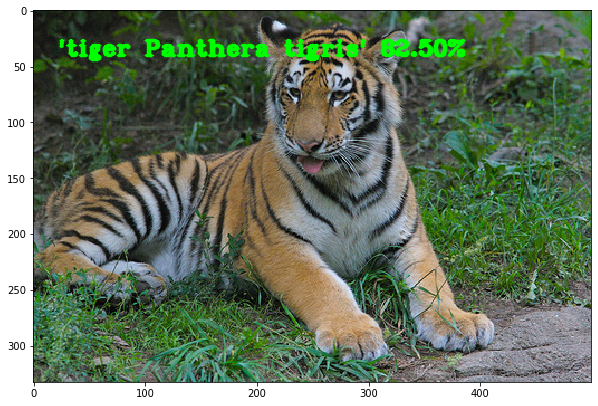

In [22]:
test_idx = 1
img_path = img_path_list[test_idx]
pred_cls_idx, pred_cls_str, prob = get_inference(img_path, predictor)

마지막으로 latency를 측정합니다. 본 예제는 CPU만으로 추론을 수행해도 충분합니다.

In [25]:
import time
start = time.time()
for _ in range(100):
    response = predictor.predict(payload)
neo_inference_time = (time.time()-start)
print(f'Neo optimized inference time is {neo_inference_time:.4f} ms')

Neo optimized inference time is 3.0248 ms


## Endpoint Clean-up

SageMaker Endpoint로 인한 과금을 막기 위해, 본 핸즈온이 끝나면 반드시 Endpoint를 삭제해 주시기 바랍니다.

In [26]:
predictor.delete_endpoint()